In [1]:
# Math libraries
import numpy as np
import random
import scipy
from scipy.linalg import sqrtm
from scipy.stats import multivariate_normal
from scipy.integrate import odeint

# I/O libraries
import os

# Graphical Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

In [2]:
#----------------------------------------------
#   FUNCTIONS
#----------------------------------------------

def h_operator(nx,obs_vect):
    
    #nx=len(obs_vect)
    index_obs=np.where(obs_vect>-999)[0]
    num_obs=len(index_obs)
    
    h_matrix=np.zeros((num_obs,nx))
    for i in range(num_obs):
        h_matrix[i,index_obs[i]]=1
        
    return h_matrix

In [3]:
def gaussian_mixt(weight_vect,n_obs,ens_vect,obs_vect,h_matrix,cov_matrix):
    
    norm_factor=1/np.sqrt(((2*np.pi)**n_obs)*np.linalg.det(cov_matrix))
    weight_mixt=np.zeros(len(weight_vect))
    weight_final=np.zeros(len(weight_vect))
    prob_dens=np.zeros(len(weight_vect))
    
    for i in range(ens_vect.shape[1]):
        innovation=obs_vect[:,0]-h_matrix.dot(ens_vect[:,i])
        prob_dens[i]=norm_factor*np.exp(-(1/2)*((np.transpose(innovation))).dot(np.linalg.inv(cov_matrix).dot(innovation)))
        weight_mixt[i]=prob_dens[i]*weight_vect[i]
        
    weight_final=weight_mixt/np.sum(weight_mixt)
    
    return weight_final

In [4]:
def agsm(mem,nx,ensemble,obs_vect,r_obs,w_prev):
    
    index_obs=np.where(obs_vect>-999)[0]
    num_obs=len(index_obs)

    # Organize the prior vector
    #prior_vect=np.transpose(ensemble)
    prior_vect=ensemble
    
    # Calculate the prior covariance matrix
    mean_prior=np.mean(prior_vect,axis=1)
    cov_prior=(h**2)*np.cov(prior_vect)
    
    
    # ------------------------
    #  Localization
    #------------------------
    r_influ=3
    tmp = np.zeros((nx, nx))
    for i in range(1, 3*r_influ+1):
        tmp += np.diag(np.ones(nx-i), i) + np.diag(np.ones(nx-i), -i) + \
               np.diag(np.ones(i),nx-i) + np.diag(np.ones(i), -(nx-i))
        tmp *= np.exp(-i**2 / r_influ**2)
    mask = tmp + np.diag(np.ones(nx))
    cov_prior=np.multiply(cov_prior,mask)
#     ------------------------
    
#     # Perturbed observation vector
    obs_vect_filtered=obs_vect[index_obs]
    obs_vect_perturbed=np.zeros((num_obs,mem))
    eps_vect=np.zeros((num_obs,mem))
    
    for i in range(mem):
        eps_vect[:,i]=np.random.normal(0,r_obs,len(index_obs))
        obs_vect_perturbed[:,i]=obs_vect_filtered[:,0]+eps_vect[:,i]  
    cov_obs=np.identity(num_obs)*r_obs**2
    
    
#     # Calculate the observation operator
    h_matrix=h_operator(nx,obs_vect)  
    
#     # Calculate the kalman gain
    k_left=cov_prior.dot(np.transpose(h_matrix)) 
    sigma_cov=h_matrix.dot(cov_prior).dot(np.transpose(h_matrix))+cov_obs 
    k_right_inv=np.linalg.inv(sigma_cov)
    kalman_gain=k_left.dot(k_right_inv)
    
#     # Calculate the innovation
    innovation=obs_vect_perturbed-h_matrix.dot(prior_vect)
    
#     # Calculate the posterior
    posterior_vect=prior_vect+kalman_gain.dot(innovation)
    mean_posterior=np.mean(posterior_vect, axis=1)
    cov_posterior=np.cov(posterior_vect)
    
    # Recalculation of the weights
    w_t= gaussian_mixt(w_prev,num_obs,posterior_vect,obs_vect_perturbed, h_matrix,sigma_cov)
    
    # Degeneracy evaluation
    N_eff=1/np.sum(w_t**2)

    #alpha=N_eff*(1/mem) # @Hamed: Play with the alpha factor here
    alpha=N_eff/mem
    
    # Recalculation of the weights considering the parameter alpha 

    # w_t=alpha*w_t+(1-alpha)*(1/mem)
    w_t=w_t*alpha+(1-alpha)*(1/mem)
    
    # Resampling

    if N_eff < nc_threshold :

        I =np.arange(0,mem,1)

        random_sample=np.random.multinomial(mem,w_t)
        J=np.zeros(mem)
        index_start=0
        for l in range(mem):
            index_end=index_start+random_sample[l]
            J[index_start:index_end]=l
            index_start=index_end

        eps=np.random.normal(0,1,mem)
        for i in range(mem):
            prior_vect[:,i]=prior_vect[:,int(J[i])] + np.sqrt(np.diag(cov_posterior))*eps[i] # Check if it makes sense to use the diagonal    
        cov_prior=(h**2)*np.cov(posterior_vect) # @Hamed: Play with the alpha factor
        
    else:
        prior_vect=posterior_vect.copy()
        cov_prior=cov_posterior.copy()
        

    
    agsm={"posterior":posterior_vect,"innovation":innovation,"weights": w_t, "alpha": alpha,
          "mean_post":mean_posterior,"cov_post":cov_posterior,"post_matrix":posterior_vect}
    
    return agsm

In [5]:
# Version 1

def L96_RK4(X, dt, F):
    # integrate for L96 model using RK4
    # X is the input, dt is the time resolution
    # X_out is the output

    dim = len(X)
    k1 = np.zeros(dim)
    k2 = np.zeros(dim)
    k3 = np.zeros(dim)
    k4 = np.zeros(dim)
    X_out = np.zeros(dim)

    # parameter for the model
    # F = 8;

    tmp_b = X.copy()  # before integration
    
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k1 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + 0.5 * k1 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k2 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + 0.5 * k2 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k3 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + k3 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k4 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    X_out = X + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return X_out


In [6]:
def calc_X(X):
    # Calculate X_p1, X_00, X_n1, and X_n2
    X_p1 = np.roll(X, -1, axis=0)
    X_00 = X.copy()
    X_n1 = np.roll(X, 1, axis=0)
    X_n2 = np.roll(X, 2, axis=0)
    return X_p1, X_00, X_n1, X_n2

def L96_RK4_ensemble(X_in, dt, F):
    """
    Integrate the Lorenz 96 model using RK4 for an ensemble of n_mem members
    
    Parameters:
    -----------
    X_in: numpy.ndarray
        Input array of shape (dim, n_mem)
    dt: float
        Time resolution
    F: float
        Parameter for the model
    
    Returns:
    --------
    X_out: numpy.ndarray
        Array of shape (dim, n_mem) containing the output of the integration
    """
    dim, n_mem = X_in.shape
    k1 = np.zeros((dim, n_mem))
    k2 = np.zeros((dim, n_mem))
    k3 = np.zeros((dim, n_mem))
    k4 = np.zeros((dim, n_mem))
    X_out = np.zeros((dim, n_mem))

    tmp_b = X_in.copy()  # before integration
    
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b)

    # Calculate k1
    k1 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b2 = X_in + 0.5 * k1 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b2)

    # Calculate k2
    k2 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b3 = X_in + 0.5 * k2 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b3)

    # Calculate k3
    k3 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b4 = X_in + k3 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b4)

    # Calculate k4
    k4 = (X_p1 - X_n2) * X_n1 - X_00 + F

    X_out = X_in + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return X_out


In [7]:
# Test for Lorenz 96 Ensemble Forward Model 2023/03/10
# by Hamed Ali Diab-Montero
# h.a.diabmontero@tudelft.nl\

# TRUTH
F = 3.85
n_x = 24                       # size of the state vector
X_in = F*np.ones((n_x,1))      # initial condition (for steady state)
#X_in[0,0] += 0.01  # Add small perturbation to the first variable

X_in[n_x//5:n_x:n_x//5] = F+1  # perturbed IC (to generate chaotic behavior)

# Time information
warm_nt = 1000                 # number of warm-up time steps
n_t = 5000                     # number of time steps to simulate
tstep = 0.01                   # time step size

t_truth = np.zeros(warm_nt + n_t)
t_truth[0] = tstep
for t in range(warm_nt + n_t - 1):
    t_truth[t+1] = t_truth[t] + tstep

X_truth = np.zeros((n_x, warm_nt + n_t))
X_truth[:,0] = X_in[:,0]
for t in range(warm_nt + n_t - 1):
    X_truth[:,t+1] = L96_RK4(X_truth[:,t], tstep, F)

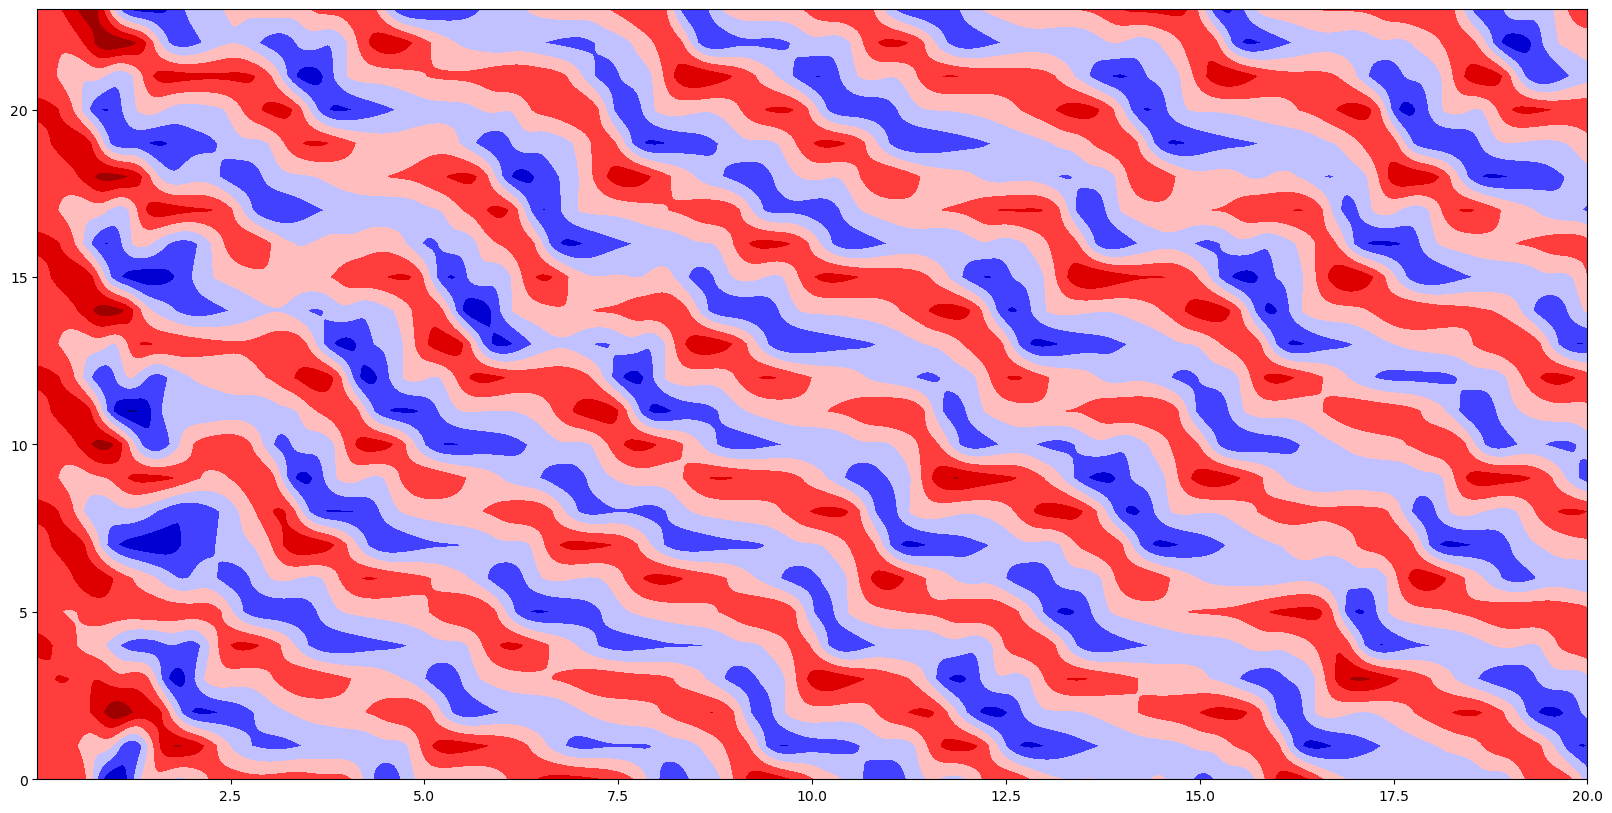

In [8]:
X_truth.shape
fig=plt.figure(figsize=(20,10))
x=t_truth
y=range(n_x)
X,Y = np.meshgrid(x,y)
# plt.pcolor(X[:,0:2000],Y[:,0:2000],X_truth[:,0:2000],cmap='seismic')
plt.contourf(X[:,0:2000],Y[:,0:2000],X_truth[:,0:2000],cmap='seismic')

In [9]:
#OBSERVATIONS
obs_rate = 50      # interval of time steps between observations
obs_den = 1        # observation density (every obs_den -th grids are observed)
t_obs = t_truth[::obs_rate]
index_truth = range(len(t_truth))

mu_pert = 0
sigma_pert = 1.5

# Dataset to test method
# x_dataset = np.loadtxt('obs_l96_40_100000.txt')

# Observations
r_eps = np.sqrt(1)
mu_pert = 0
pert_obs = np.random.normal(mu_pert, r_eps, [ len(t_obs), int(n_x/obs_den)])

n_obs = 2
# NOTE: @Hamed -->modify from here
x_obset = np.ones((len(t_obs), n_x+2)) * -999
x_obset[:, 0] = t_obs
x_obset[:,1] = index_truth[::obs_rate]
x_obset[:, 2::obs_den] = np.transpose(X_truth[::obs_den,::obs_rate]) + pert_obs

# t_first_da = 10
# n_obs = np.count_nonzero(x_obset[t_first_da, 1:] > -999)

# r_eps = 0.3

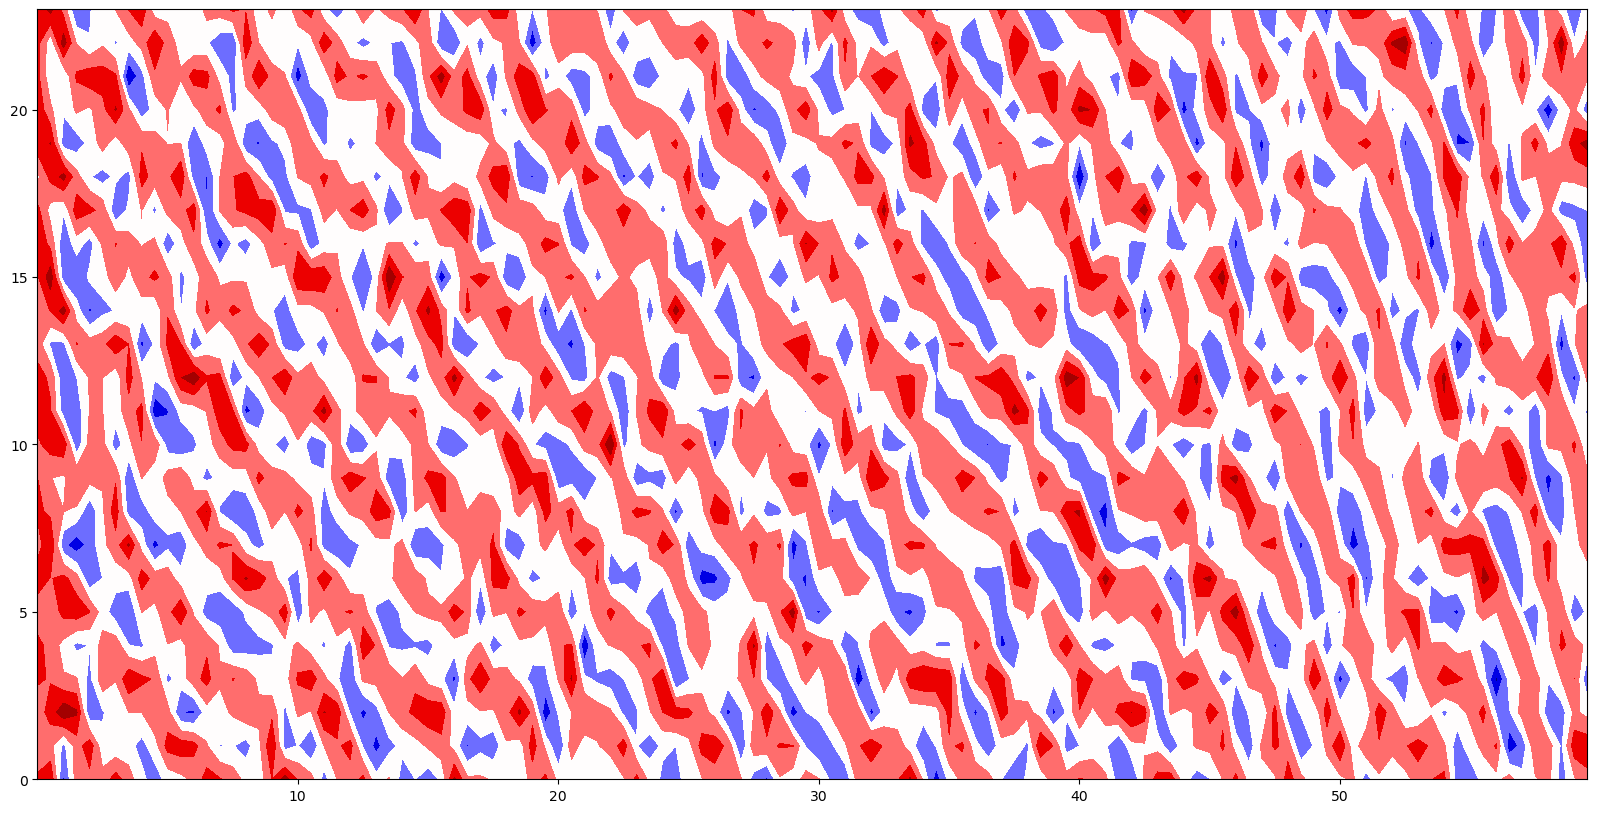

In [10]:
fig=plt.figure(figsize=(20,10))
x=t_obs
y=range(n_x)
X,Y = np.meshgrid(x,y)
# plt.pcolor(X,Y,np.transpose(x_obset[:,2:]),cmap='seismic')
plt.contourf(X,Y,np.transpose(x_obset[:,2:]),cmap='seismic')

In [11]:
#-----------------------------------------
# Adaptive Gaussian Mixture Filter
#-----------------------------------------

# Initialization
t = 0

n_mem = 100     # N - Ensemble size
# n_x = 40          # size of the state vector

# Experiment specific:
# Assimilate observation at time=1000 s
n_t = 6000       # number of time steps
tstep = 0.01

# Select h and Nc
nc_threshold=0.8*n_mem # Nc threshold
h_opt=n_mem**(-1/5)
h=1.5*h_opt # Bandwidth parameter

# Creation of the weight diagonal matrix
w_0=(1/n_mem)*np.ones(n_mem)
W_0=(1/n_mem)*np.eye(n_mem)

W_prev=W_0.copy()
w_prev=w_0.copy()

# Define X0 by x0, i=1 ... N
# Replacing the values with the initial value of X_0
x_vector = np.zeros((n_x, n_mem))   # state vector
X_0 = np.loadtxt('prior_l96_40_100_particles.txt')

# PICKING ONLY N BLOCKS
index_block=list(np.array(random.sample(list(enumerate(X_0[:,0])),n_x))[:,0])
index_block=list(map(int, index_block))
x_vector[:,:]=X_0[index_block,:]
X_0=x_vector[:,:]

In [12]:
#
# COVARIANCE CALCULATION
#

B_0=np.cov(X_0)
# ------------------------
#  Localization
#------------------------
r_influ=3
tmp = np.zeros((n_x, n_x))
for i in range(1, 3*r_influ+1):
    tmp += np.diag(np.ones(n_x-i), i) + np.diag(np.ones(n_x-i), -i) + \
           np.diag(np.ones(i),n_x-i) + np.diag(np.ones(i), -(n_x-i))
    tmp *= np.exp(-i**2 / r_influ**2)
mask = tmp + np.diag(np.ones(n_x))
B_0=np.multiply(B_0,mask)
#     ------------------------
P_0=(h**2)*B_0;

# initial condition
ctlmean = X_truth[:, 0] + np.random.multivariate_normal(np.zeros(n_x), np.eye(n_x)).T
n_t=len(t_truth)
X_t = np.zeros((n_x, n_mem, n_t))
Q = 2 * np.eye(n_x)            # background error covariance (only for the initial perturbation)
Q_inv = np.linalg.inv(Q)
X_t[:,:,0] = np.random.multivariate_normal(ctlmean, Q, n_mem).T

t_first_da = int(warm_nt/obs_rate)+1 # index first assimilation 
n_obs = np.sum(x_obset[t_first_da, 2:] > -999)

# Foward model spin-up

t = warm_nt+1
# We will assimilate this number of steps
# t_assim < len(t_truth)-obs_rate 
t_assim = len(t_truth)-50

for k in range(warm_nt):
    X_t[:,:,k+1] = L96_RK4_ensemble(X_t[:,:,k], tstep, F)

#
# Saving Files
#
t_summary=[]
h_summary=[]
alpha_summary=[]
weight_summary=[]

In [13]:
d = t_first_da

while t*tstep < t_assim*tstep:
    t_analysis = int(np.ceil(t_obs[d]/tstep))

    for k in range(t, t_analysis,1):
        X_t[:,:,k] = L96_RK4_ensemble(X_t[:,:,k-1], tstep, F)
#         alpha_summary.append(post_agsm['alpha'])
        weight_summary.append(w_prev.copy())
        t_summary.append(k)
    
    t = t_analysis

    h_summary.append(h)
    
    # Observations
    y_t = np.zeros((n_obs, 1))
    index_obs = np.where(x_obset[d, 2:] > -999)[0] # Experiment specific
    y_t[:, 0] = x_obset[d, 2:][index_obs] # Experiment specific

    # Adaptive Gaussian Mixture Filter part of the method
    post_agsm = agsm(n_mem, n_x, X_t[:, :, t-1], y_t, r_eps, w_prev)

    X_ens_mean=post_agsm['mean_post'].copy()
    X_ens=post_agsm['post_matrix'].copy()
    P_ens=post_agsm['cov_post'].copy()
    w_prev=post_agsm['weights'].copy()

    
    X_t[:, :, t-1] = X_ens.copy()
    P_t = P_ens.copy()   
    
    d += 1
    
    
print('Finished with the estimation')

Finished with the estimation


In [14]:
weight_matrix=np.zeros((len(weight_summary[0]),len(weight_summary)))
for i in range(len(weight_summary)):
    weight_matrix[:,i]=weight_summary[i]

# Plot results

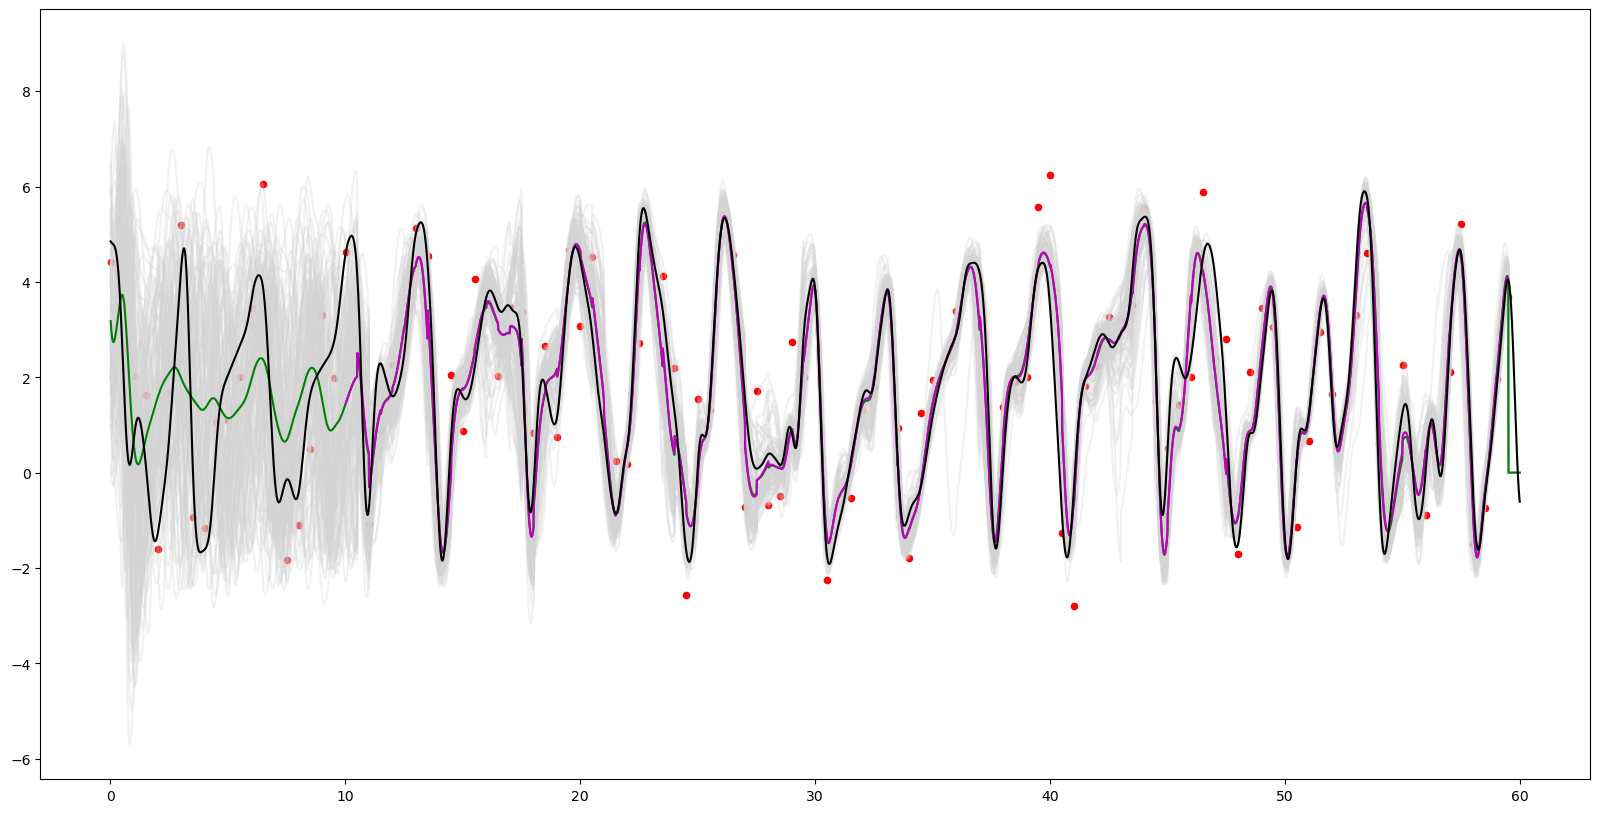

In [15]:
index_variable=8
fig=plt.figure(figsize=(20,10))
for i in range(n_mem):
    plt.plot(t_truth,X_t[index_variable,i,:],color='lightgray',alpha=0.3)
plt.plot(t_truth,np.mean(X_t[index_variable,:,:],axis=0),color='green')
plt.plot(t_truth[warm_nt+1:t_assim],np.sum(np.multiply(weight_matrix[:,1:],X_t[index_variable,:,warm_nt+1:t_assim]),axis=0),color='m')
plt.plot(t_truth,X_truth[index_variable,:],color='k')
plt.scatter(t_obs,x_obset[:,index_variable+2],color='r',s=20)
# plt.scatter(t_obs,x_obs,color='r',s=100)

# RMSE

In [16]:
#
#  RMSE CALCULATION
#

X_t_mean=np.mean(X_t,axis=1)
X_t_agsm=np.zeros((n_x,len(t_truth[warm_nt+1:t_assim])))
for i in range(n_x):
    X_t_agsm[i,:]=np.sum(np.multiply(weight_matrix[:,1:],X_t[i,:,warm_nt+1:t_assim]),axis=0)
print(X_t_mean.shape)

#t_truth[warm_nt+1:t_assim]

error_x_t=np.zeros((n_x,len(t_truth)))
error_x_agsm=np.zeros((n_x,len(t_truth[warm_nt+1:t_assim])))
for i in range(n_x):
    error_x_t[i,:]=(X_t_mean[i,:]-X_truth[i,:])**2
    error_x_agsm[i,:]=(X_t_agsm[i,:]-X_truth[i,warm_nt+1:t_assim])**2
    
rmse_x_t=np.sqrt((1/n_x)*np.sum(error_x_t,axis=0))
rmse_x_agsm=np.sqrt((1/n_x)*np.sum(error_x_agsm,axis=0))

(24, 6000)


Text(0, 0.5, 'RMSE')

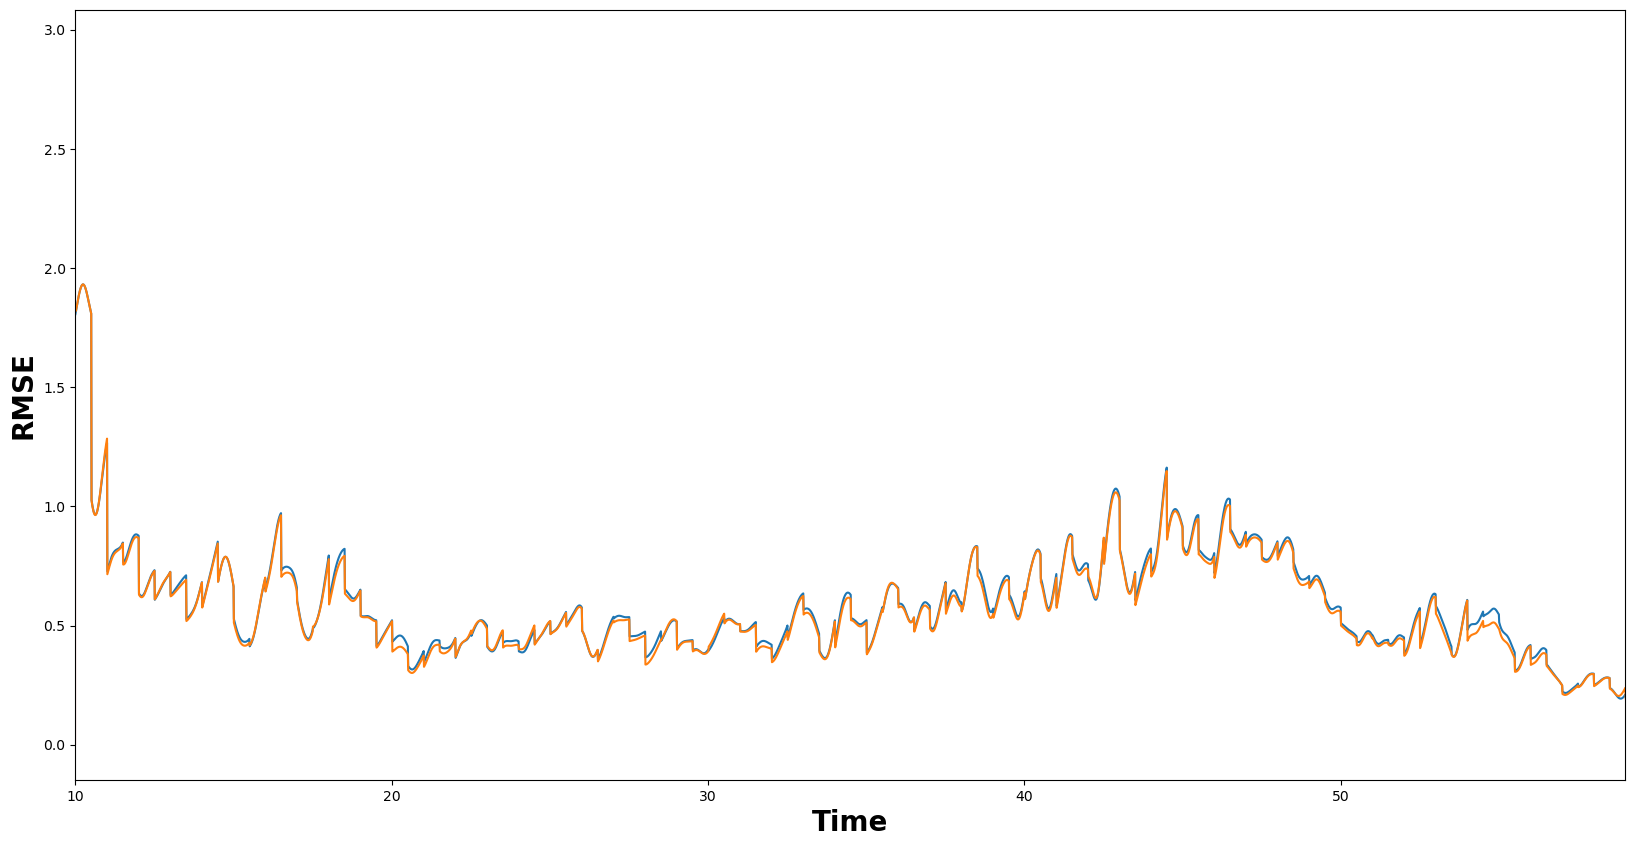

In [17]:
fig=plt.figure(figsize=(20,10))
plt.plot(t_truth,rmse_x_t)
plt.plot(t_truth[warm_nt+1:t_assim],rmse_x_agsm)
plt.vlines(x=10,ymin=0,ymax=1,label='start data assimilation',color='r')
plt.xlim(10,59)
plt.xlabel('Time',fontsize=20,fontweight='bold')
plt.ylabel('RMSE',fontsize=20,fontweight='bold')

Text(0, 0.5, 'RMSE')

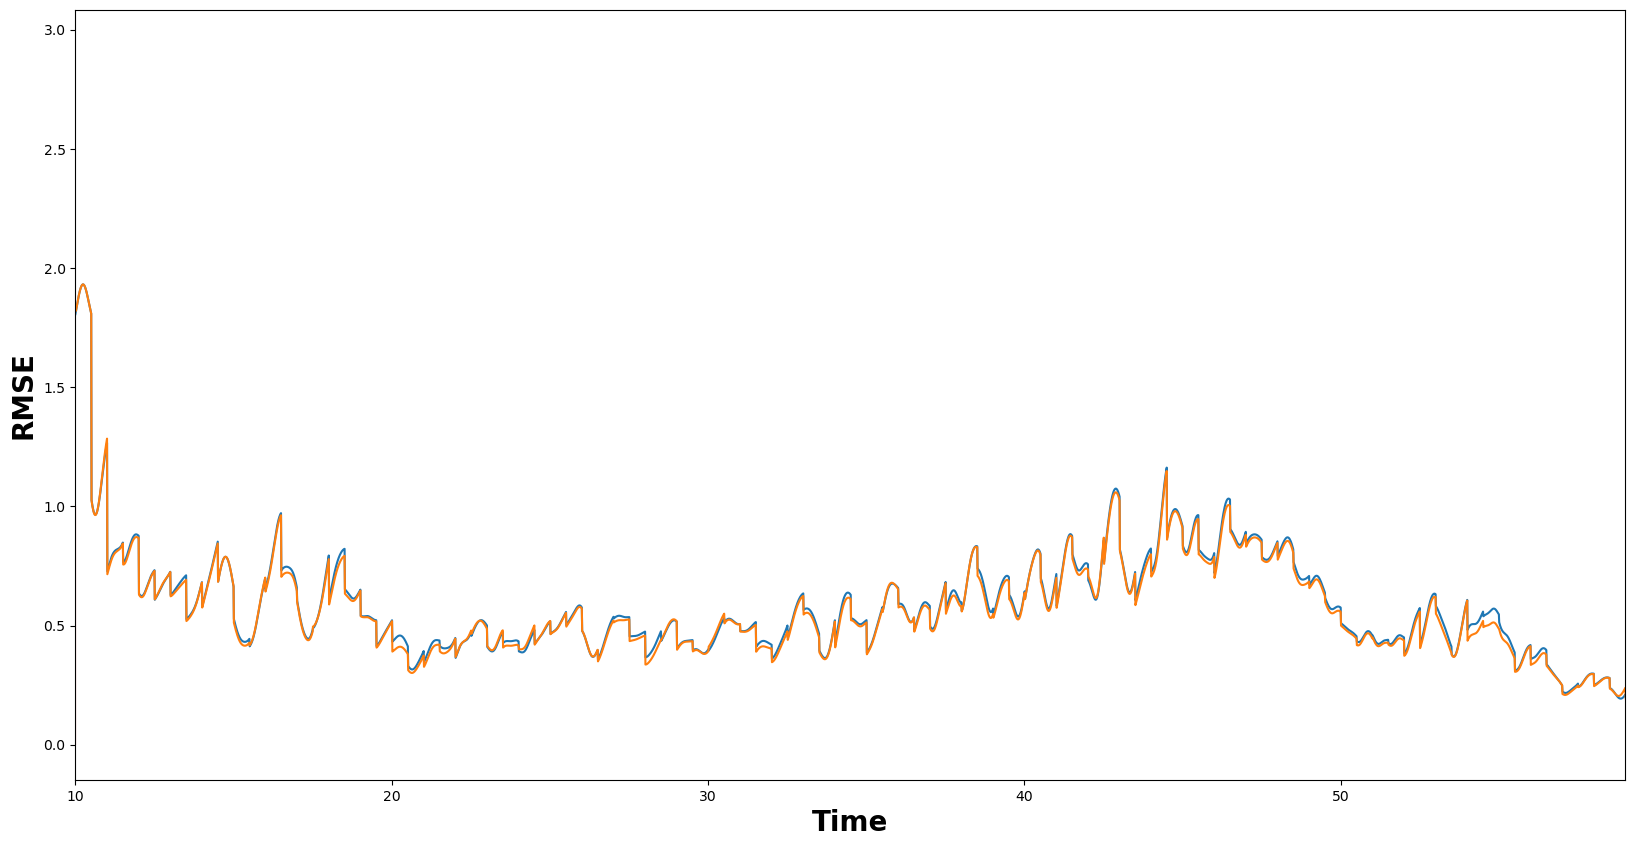

In [18]:
fig=plt.figure(figsize=(20,10))
plt.plot(t_truth,rmse_x_t)
plt.plot(t_truth[warm_nt+1:t_assim],rmse_x_agsm)
plt.vlines(x=10,ymin=0,ymax=1,label='start data assimilation',color='r')
plt.xlim(10,59)
plt.xlabel('Time',fontsize=20,fontweight='bold')
plt.ylabel('RMSE',fontsize=20,fontweight='bold')

In [19]:
# SAVE FILES
n_run_exp='10'

filename='./results_rmse/rmse_l96_chaotic_obs_freq_03_run_'+n_run_exp+'.txt'
results_rmse=np.zeros((len(t_truth[warm_nt+1:t_assim]),2))
results_rmse[:,0]=t_truth[warm_nt+1:t_assim]
results_rmse[:,1]=rmse_x_agsm[:]

np.savetxt(filename,results_rmse)